In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os, sys
import datetime as dt
import scipy
import math
import warnings
import random
from datetime import timedelta
from extract_features import get_time_series_features, get_freq_domain_features

warnings.filterwarnings('ignore')

ROOT_DIR = os.getcwd()

## Assignment 2: Activity Recognition
**Name: Ha Le**
**Date: Oct. 11st, 2022**

### Step 1: Load the Data

The chunk of code below clean and load the raw dataset from the assignment page. Upon viewing the file, I saw that many datapoints are not seperated by line, so we'll have to clean up a bit before we can use pandas to import the dataset.

In [71]:
# First, open the file
data_file = open(ROOT_DIR + '/../data/raw/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', "r")
# print(data_file.read())
#split the data points by ";" and store them in a list
data = data_file.read().split(';')
# print(data)
#remove the new line symbol from each of the items in the list
data = [x.replace('\n', '') for x in data]
#write the data to a new file
with open(ROOT_DIR + '/../data/clean/WISDM_ar_v1.1_raw.txt', 'w') as f:
    for item in data:
        if len(item.split(',')) !=  6:
            continue
        f.write("%s\n" % item)

# Importing the dataset
dataset = pd.read_csv(ROOT_DIR + '/../data/clean/WISDM_ar_v1.1_raw.txt', header=None, names=['user-id', 'activity', 'timestamp', 'x', 'y', 'z'])
# remove all rows with timestamp = 0
dataset = dataset[dataset['timestamp'] != 0]
# convert the timestamp to a datetime object
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
print(f"Length of the dataset: {len(dataset)}")
dataset.head()

Length of the dataset: 1073629


,user-id,activity,timestamp,x,y,z
0,33,Jogging,1970-01-01 13:38:25.962326,-0.694638,12.680544,0.503953
1,33,Jogging,1970-01-01 13:38:26.062271,5.012288,11.264028,0.953424
2,33,Jogging,1970-01-01 13:38:26.112167,4.903325,10.882658,-0.081722
3,33,Jogging,1970-01-01 13:38:26.222305,-0.612916,18.496431,3.023717
4,33,Jogging,1970-01-01 13:38:26.332290,-1.184970,12.108489,7.205164


### Step 2: Data Cleaning and Pre-processing

Next, we will need to seperate our dataset into different smaller dataset based on the user-id, so we can perform noise removal and segmentation seperatedly for different subjects:

In [72]:
# remove null values from the dataset
dataset = dataset.dropna()

#calculate the magnitude of the acceleration
dataset['magnitude'] = np.sqrt(dataset['x']**2 + dataset['y']**2 + dataset['z']**2)

# see the number of rows in the dataset left
print(f"Length of the dataset after removing null values: {len(dataset)}")
#  break the dataset into different smaller datasets based on the user-id
user_ids = dataset['user-id'].unique()
# print(user_ids)
# create a dictionary to store the different datasets
user_data = {}
for user_id in user_ids:
    user_data[user_id] = dataset[dataset['user-id'] == user_id]
    # sort the dataset based on the timestamp in case we have some out of order data
    user_data[user_id] = user_data[user_id].sort_values(by='timestamp')
# print(user_data)

Length of the dataset after removing null values: 1073629


We want to visualize some of the data from the subjects. I wrote a function, given the user-id, will draw the raw accelerometer data of that user:

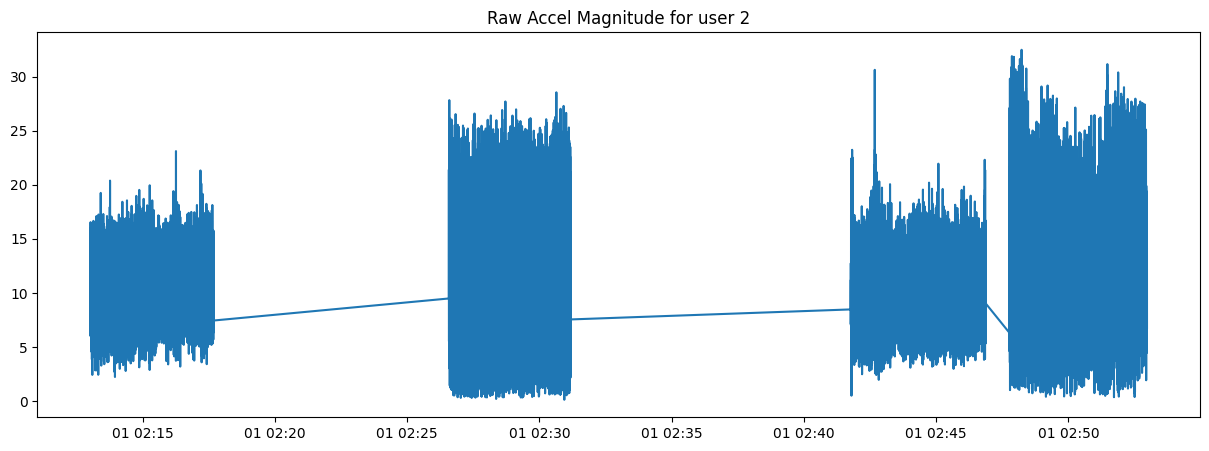

In [73]:
def visualize_raw_accel(timestamp, signal, title):
    """
    Visualize the signal data for a given list of accelerations
    :param user_id: the user id to visualize
    :return: None
    """
    plt.figure(figsize=(15, 5))
    # print("pass 1")
    plt.plot(timestamp, signal)
    plt.title(title)
    plt.show()

#test the function on a user
visualize_raw_accel(user_data[2]['timestamp'], user_data[2]['magnitude'], 'Raw Accel Magnitude for user 2')

It seems like the data is not collected consecutively, but seperated into several chunks. Hence, when we segmented the data, we should take this into consideration. To make life easier, let's further divided our dataframes into different smaller dataframe where the timestamps are continuous.

I wrote a function, seperate_df_based_on_timestamp() that take a user ID, and seperate the dataset for that user into smaller dataframes, each of them are temporal consecutive data represented new chunk of activities. To test if the function behaves according to our intention, we can test the result against user 2. From the graph above, it looks like user 2 has 4 different chunks of activities.

In [74]:
def seperate_df_based_on_timestamp(user_id: int):
    '''
    This function is used to seperate the dataframe based on the timestamp.
    If the time difference between two consecutive rows is greater than 2 
    second, then we will consider it as a new chunk of activities.
    If the chunk has more than 1 activity, than we will divide it further.
    :param user_id: the user id to visualize
    :return: List of dataframes
    '''

    user_df = user_data[user_id]
    # sort the dataset based on the timestamp in case we have some out of order data
    user_df = user_df.sort_values(by='timestamp')
    #create another column to store the time difference between two consecutive rows
    user_df['time_diff'] = user_df['timestamp'].diff().dt.total_seconds()
    #reset the index
    user_df = user_df.reset_index(drop=True)

    #get the entries in time_diff column where the time difference is greater than 1 second
    time_diff = [0] + user_df[user_df['time_diff'] > 2].index.tolist() + [len(user_df) - 1]

    #remove the time_diff column
    user_df = user_df.drop(columns=['time_diff'])

    df_list = []
    # split the datafram at the indices where the time difference is greater than 1 second
    for index in range(len(time_diff) - 1):
        # print("split points: ", time_diff[index], time_diff[index + 1])
        new_chunk = user_df.iloc[time_diff[index]:time_diff[index + 1]]
        # print(new_chunk)
        df_list.append(new_chunk)
    
    return df_list

#test the function on a user
user2_df_list = seperate_df_based_on_timestamp(2)
print(f"Number of dataframes: {len(user2_df_list)}")



Number of dataframes: 4


It looks like the function is working as we intended. Now, we want to apply the function to every user, and store all the dataframe into a dictionary, for the sake of retrieval.

I also made a report of all the dataframe to examine if there is anything weird going on (very short chunk, for example). You can view the full version of the report [here]("Assignment2/reports/user_activity_chunk_summary.csv") (it's in the "report/user_activity_chunk_summary.csv" file).

In [75]:
user_id_lst = dataset['user-id'].unique()
user_id_lst.sort()
user_activity_dict = {i:{} for i in user_id_lst}

for user_id in user_id_lst:
    # get the list of activity dataframes for the user
    user_df_list = seperate_df_based_on_timestamp(user_id)

    activity_chunk_id = 0
    #store this in the user_activity_dict
    for activity_df in user_df_list:
        # if the length of the dataframe is less than 100, then we will not consider it
        # as a valid activity (since it is too short - less than 5 seconds)
        if len(activity_df) < 100:
            continue
        #store the activity dataframe in the dictionary
        user_activity_dict[user_id][activity_chunk_id] = activity_df
        activity_chunk_id += 1

#summary of the user_activity_dict
# create a dataframe to store the summary of the user_activity_dict
user_activity_summary = pd.DataFrame(columns=['user-id', 'activity', 'start-time', 'end-time', 'duration', 'num-rows', 'num-activities'])
# iterate through the user_activity_dict and store the summary in the dataframe
for user_id in user_activity_dict.keys():
    for activity_chunk_id in user_activity_dict[user_id].keys():
        # get the activity dataframe
        activity_df = user_activity_dict[user_id][activity_chunk_id]
        if len(list(activity_df["timestamp"])) == 0:
            print("Empty dataframe")
            print("User ID: ", user_id)
            print("Activity Chunk ID: ", activity_chunk_id)
            continue
        # get the start and end time
        start_time = list(activity_df['timestamp'])[0]
        end_time = list(activity_df['timestamp'])[-1]
        # get the duration
        duration = end_time - start_time
        # convert the duration to seconds
        duration = duration.total_seconds()
        # get the number of rows
        num_rows = len(activity_df)
        # get the activity
        activity = activity_df['activity'].iloc[0]
        #get the number of activities
        num_activities = len(activity_df['activity'].unique())
        # add the summary to the dataframe
        user_activity_summary = user_activity_summary.append({'user-id': user_id, 'activity': activity, 'start-time': start_time, 
            'end-time': end_time, 'duration': duration, 'num-rows': num_rows, "num_activities": num_activities}, ignore_index=True)

# export the report to a csv file
user_activity_summary.to_csv(ROOT_DIR + '/../reports/user_activity_chunk_summary.csv', index=False)
# print the head of the summary
print(user_activity_summary.head())


  user-id activity                 start-time                   end-time  \
0       1  Walking 1970-01-01 01:23:11.922345 1970-01-01 01:28:51.942304   
1       1  Jogging 1970-01-01 01:29:34.662305 1970-01-01 01:33:44.562299   
2       1  Walking 1970-01-01 01:34:27.992292 1970-01-01 01:37:01.602369   
3       1  Walking 1970-01-01 01:37:05.572339 1970-01-01 01:39:34.872327   
4       1  Jogging 1970-01-01 01:39:55.682355 1970-01-01 01:44:58.492292   

     duration num-rows num-activities  num_activities  
0  340.019959     6801            NaN             1.0  
1  249.899994     4999            NaN             1.0  
2  153.610077     3073            NaN             1.0  
3  149.299988     2987            NaN             1.0  
4  302.809937     6057            NaN             1.0  


Let's visualize one of the signal to see if we need to do any noise removal beforehand. 

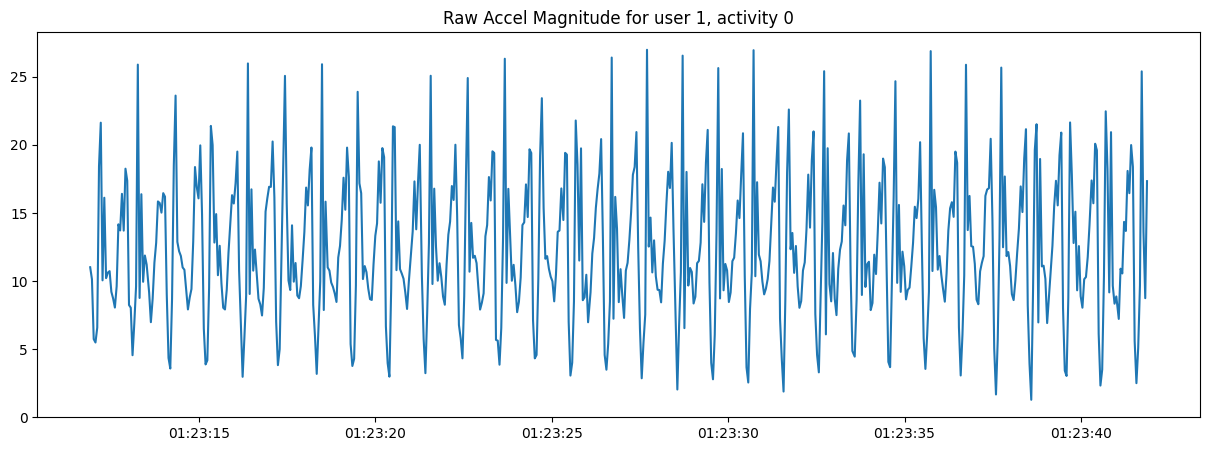

In [76]:
# plot the magnitude signal for the first chunk of activity for user 1, but only plot the first 600 rows (roughly 30 seconds)
visualize_raw_accel(user_activity_dict[1][0]['timestamp'][:600], user_activity_dict[1][0]['magnitude'][:600], 'Raw Accel Magnitude for user 1, activity 0')


The signal looks quite crowded and noisy. I will use a simple low-pass filter (similar to what I did in project 1) to remove some of the noise.

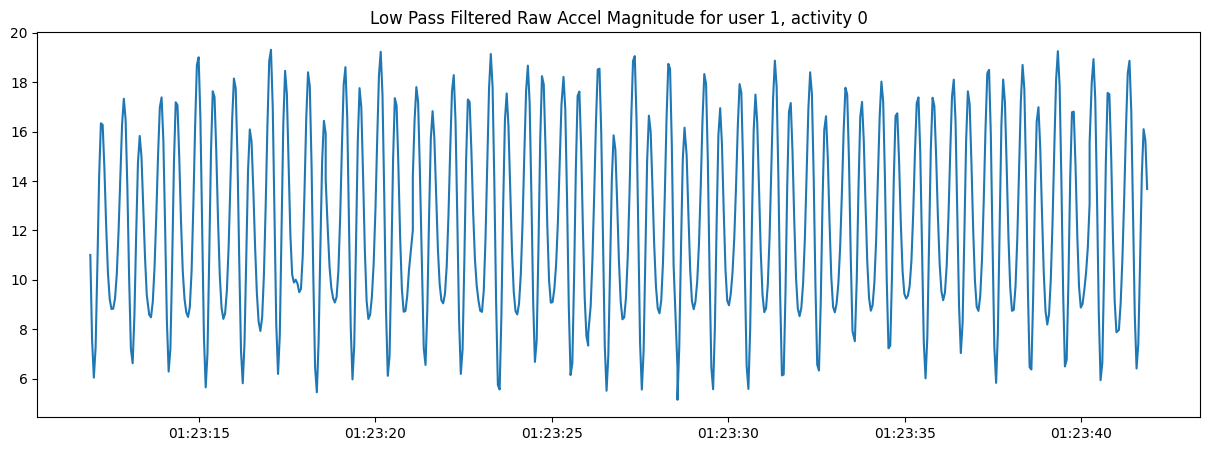

In [77]:
def low_pass_filter(data, cutoff, fs, order=5):
    '''
    This function is used to apply a low pass filter to the data
    :param data: the data to filter
    :param cutoff: the cutoff frequency
    :param fs: the sampling frequency
    :param order: the order of the filter
    :return: the filtered data
    '''
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = scipy.signal.filtfilt(b, a, data)
    return y

#set the sampling frequency
fs = 20
#set the cutoff frequency
cutoff = 3

#apply the low pass filter to the magnitude signal
user_activity_dict[1][0]['magnitude'] = low_pass_filter(user_activity_dict[1][0]['magnitude'], cutoff, fs)

#plot the magnitude signal for the first chunk of activity for user 1, but only plot the first 600 rows (roughly 30 seconds)
visualize_raw_accel(user_activity_dict[1][0]['timestamp'][:600], user_activity_dict[1][0]['magnitude'][:600], 'Low Pass Filtered Raw Accel Magnitude for user 1, activity 0')

The signal after applying the low-pass filter looks pretty clean. Let's apply it to all other dataframes, and plot the magnitude for the random activity chunk of a random user to confirm that our filter works:

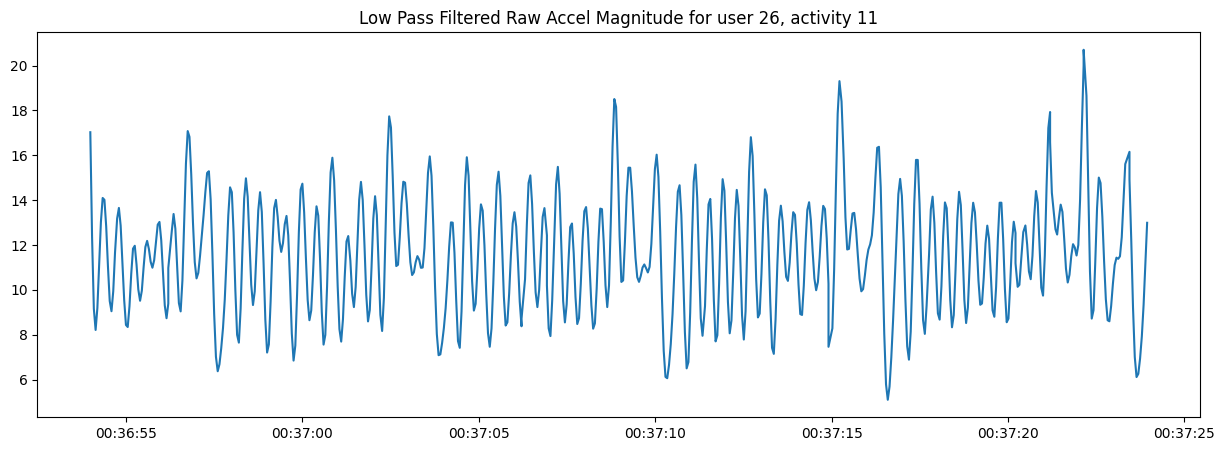

In [78]:
# apply the low pass filter to all the data
for user_id in user_activity_dict.keys():
    for activity_chunk_id in user_activity_dict[user_id].keys():
        # get the activity dataframe
        activity_df = user_activity_dict[user_id][activity_chunk_id]
        # apply the low pass filter to the magnitude signal
        activity_df['magnitude'] = low_pass_filter(activity_df['magnitude'], cutoff, fs)
        # apply the low pass filter to the x signal
        activity_df['x'] = low_pass_filter(activity_df['x'], cutoff, fs)
        # apply the low pass filter to the y signal
        activity_df['y'] = low_pass_filter(activity_df['y'], cutoff, fs)
        # apply the low pass filter to the z signal
        activity_df['z'] = low_pass_filter(activity_df['z'], cutoff, fs)
        # store the activity dataframe back in the dictionary
        user_activity_dict[user_id][activity_chunk_id] = activity_df

# plot the magnitude signal for a random chunk of activity for a random user, but only plot the first 600 rows (roughly 30 seconds)
user_id = random.choice(list(user_activity_dict.keys()))
random_chunk_id = random.randint(0, len(user_activity_dict[user_id].keys()) - 1)
try:
    visualize_raw_accel(user_activity_dict[user_id][random_chunk_id]['timestamp'][:600], user_activity_dict[user_id][random_chunk_id]['magnitude'][:600], f'Low Pass Filtered Raw Accel Magnitude for user {user_id}, activity ' + str(random_chunk_id))
except Exception as e:
    print(user_id, random_chunk_id)

### Step 3: Segmenting the Data

Now that we are done with the data cleaning process, we can start segmenting our data to feed it to a classifier. I will be using a window size of 10 seconds, according to the recommendation of the original paper:

In [85]:
# initialize the window size (in seconds)
window_size_in_seconds = 10

def segmenting_signal(signal_df: pd.DataFrame, window_size: timedelta, overlap_percent=0.5):
    '''
    This function segments the signal into overlapping windows of size window_size
    with overlap_percent overlap
    :param signal: the signal to segment
    :param window_size: the size of the window (in timedeltas)
    :param overlap_percent: the percentage of overlap between the windows
    :return: a list of the segmented signal
    '''

    # convert the window size to seconds
    window_size = window_size.total_seconds()
    # calculate the number of samples in the window
    window_samples = int(window_size * fs)
    # calculate the number of samples to overlap
    overlap_samples = int(window_samples * overlap_percent)
    # calculate the number of samples to step
    step_samples = window_samples - overlap_samples
    # calculate the number of windows
    num_windows = int((len(signal_df) - window_samples) / step_samples) + 1
    # create a list to store the segmented signal
    segmented_signal = []
    # iterate through the number of windows
    for i in range(num_windows):
        # get the start and end indices
        start_index = i * step_samples
        end_index = start_index + window_samples
        # get the window
        window = signal_df[start_index:end_index]
        # append the window to the segmented signal if there is only one activity in the window
        if len(window['activity'].unique()) == 1:
            segmented_signal.append(window)
    return segmented_signal
    
# test the function on the first chunk of activity for user 1
segmented_signal = segmenting_signal(user_activity_dict[1][0], timedelta(seconds=window_size_in_seconds))
# print the number of windows
print("Number of window: ",len(segmented_signal))
# print the length of the first window
print("Length of windows: ", [len(window) for window in segmented_signal])

Number of window:  67
Length of windows:  [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


The function seems to work well. Let apply it to all the dataset.

In [87]:
# segment the signal for all the data
segmented_dfs =[]
for user_id in user_activity_dict.keys():
    for activity_chunk_id in user_activity_dict[user_id].keys():
        # get the activity dataframe
        activity_df = user_activity_dict[user_id][activity_chunk_id]
        # segment the signal
        segmented_signal = segmenting_signal(activity_df, timedelta(seconds=window_size_in_seconds))
        # append the segmented signal to the list
        segmented_dfs.extend(segmented_signal)

#print how many segments there are
print("Number of segments: ", len(segmented_dfs))

Number of segments:  10086


### Step 4: Feature Extraction

Now that we have the segmented dataframes, we want to extract meaningful features from our signals. For each segment_df, we will extract the time/frequency domain features for the magnitude signal, and the activity label. 

I will also export the new dataset to a csv file.

In [93]:
# extract the features from the segmented signal
extracted_df = pd.DataFrame(columns=["user-id", 'sig_mean', 'sig_std', 'sig_aad', 'sig_min', 'sig_max', 'sig_maxmin_diff', 'sig_median', 
            'sig_mad', 'sig_IQR', 'sig_neg_count', 'sig_pos_count', 'sig_above_mean', 'sig_num_peaks', 'sig_skew', 'sig_kurtosis', 
            'sig_energy', 'sig_sma', 'sig_fft_dc', 'sig_fft_mean', 'sig_fft_std', 'sig_fft_aad', 'sig_fft_min', 'sig_fft_max', 
            'sig_fft_maxmin_diff', 'sig_fft_median', 'sig_fft_mad', 'sig_fft_IQR', 'sig_fft_neg_count', 'sig_fft_pos_count', 
            'sig_fft_above_mean', 'sig_fft_num_peaks', 'sig_fft_skew', 'sig_fft_kurtosis', 
            'sig_fft_energy', 'sig_fft_sma', 'activity_label'])


for df in segmented_dfs:
    # get the user id
    user_id = df['user-id'].iloc[0]
    # get the activity label
    activity_label = df['activity'].iloc[0]
    #extract time domain the features from the magnitude signal
    time_domain_features = get_time_series_features(df['magnitude'])
    #extract the features from the fft of the magnitude signal
    fft_features = get_freq_domain_features(df['magnitude'])
    #combine the features
    features = [user_id] + time_domain_features + fft_features + [activity_label]
    #append the features to the dataframe
    extracted_df.loc[len(extracted_df)] = features

# export the extracted features to a csv file
extracted_df.to_csv(ROOT_DIR + '/../data/clean/extracted_features.csv', index=False)

# print the first 5 rows of the extracted features
extracted_df.head()



,user-id,sig_mean,sig_std,sig_aad,sig_min,sig_max,sig_maxmin_diff,sig_median,sig_mad,sig_IQR,...,sig_fft_IQR,sig_fft_neg_count,sig_fft_pos_count,sig_fft_above_mean,sig_fft_num_peaks,sig_fft_skew,sig_fft_kurtosis,sig_fft_energy,sig_fft_sma,activity_label
0,1,12.206485,3.516635,3.119340,6.129499,18.884451,12.754952,11.863845,3.181666,6.624378,...,12.056263,0,100,23,11,7.201449,59.488905,2473.368028,17.306637,Walking
1,1,12.445939,3.635111,3.227841,6.129499,18.884451,12.754952,12.316625,3.430925,6.745704,...,15.580992,0,100,24,9,5.646134,37.929437,2642.815199,18.731178,Walking
2,1,12.326233,3.671387,3.265945,6.107957,18.783920,12.675963,12.146822,3.448844,6.804436,...,11.353329,0,100,22,12,6.898147,55.475299,2695.831928,17.439746,Walking
3,1,12.342743,3.490802,3.115466,6.107957,18.783920,12.675963,12.091281,3.227659,6.435994,...,7.629288,0,100,21,12,8.815947,80.838564,2437.142527,11.186557,Walking
4,1,12.458537,3.504022,3.122707,6.821652,18.847751,12.026099,12.441907,3.288527,6.533903,...,5.393483,0,100,19,14,8.621004,78.304209,2455.636816,11.793383,Walking


### Step 5: Train the Model

After extracting useful features about the signal, the next step is to train a model to perform activity recognition.